In [16]:
import pandas as pd
import numpy as np
import os
import datetime
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader ,TensorDataset
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from datetime import datetime, timedelta

In [2]:
os.listdir('.')

['.conda',
 '.InstallAnywhere',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.matplotlib',
 '.spyder-py3',
 '.vscode',
 '3D Objects',
 'anaconda3',
 'AppData',
 'Application Data',
 'Contacts',
 'Cookies',
 'Credit card fraud detection.py',
 'customer segmentation.ipynb',
 'data.csv',
 'Documents',
 'dog_app (3).ipynb',
 'Downloads',
 'Dropbox',
 'Favorites',
 'fcsdrop.ipynb',
 'flowsom#1_FlowSOM_cluster_cell_percentage.csv',
 'Forecasting model (2).ipynb',
 'Forecasting model.ipynb',
 'Links',
 'Local Settings',
 'logistic regression.py',
 'MicrosoftEdgeBackups',
 'Mulitvariate LSTM.ipynb',
 'Music',
 'My Documents',
 'NetflixEDA.ipynb',
 'netflix_titles.csv',
 'NetHood',
 'NTUSER.DAT',
 'ntuser.dat.LOG1',
 'ntuser.dat.LOG2',
 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TM.blf',
 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TMContainer00000000000000000001.regtrans-ms',
 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TMContainer00000000000000000002.regtrans-ms',
 'n

In [3]:
X_train=pd.read_csv('X_train.csv',sep=';')
Y_train=pd.read_csv('Y_train.csv',sep=';')
X_test=pd.read_csv('X_test.csv',sep=';')
Y_test=pd.read_csv('Y_test.csv',sep=';')


# Checking if the traina nd test ids are present in each other 

In [4]:
print(set(X_train['key']).difference(X_test['key']))
print(set(X_test['key']).difference(X_train['key']))

set()
set()


# Converting X_Train and X_Test features

In [5]:
features_columns=list(set(X_train.columns).difference(set(['key','date'])))

In [6]:
X_train[features_columns]=X_train[features_columns].apply(lambda a: a.replace(",",'.',regex=True)).astype(float)
X_test[features_columns]=X_test[features_columns].apply(lambda a: a.replace(",",'.',regex=True)).astype(float)
Y_train[['y']]=Y_train[['y']].apply(lambda a: a.replace(",",'.',regex=True)).astype(float)


# Convering dates to date time 

In [7]:
X_train['date']=pd.to_datetime(X_train['date'])
X_test['date']=pd.to_datetime(X_test['date'])
Y_train['date']=pd.to_datetime(Y_train['date'])
Y_test['date']=pd.to_datetime(Y_test['date'])

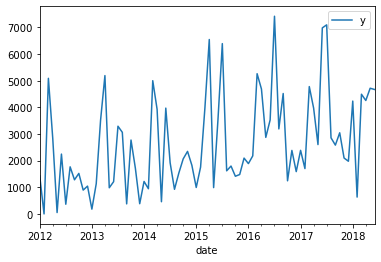

In [8]:
Y_train.query('key==683').set_index('date')[['y']].plot()

# Checking for NA in y_train

In [9]:
y_train_null=Y_train[Y_train.y.isnull()]

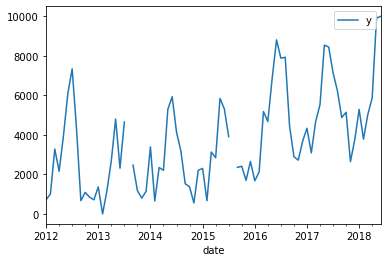

In [10]:
Y_train.query('key==95121').set_index('date')[['y']].plot()

# Replacing NAs with the average of previous and next months values for y_train

In [11]:
for i in np.arange(y_train_null.shape[0]):
    key=y_train_null.iloc[i]['key']
    date=y_train_null.iloc[i]['date']
    prev_month=date-datetime.timedelta(days=1)
    prev_month=prev_month.replace(day=1)
    next_month=date+datetime.timedelta(days=32)
    next_month=next_month.replace(day=1)
    prev_y=Y_train.loc[(Y_train['date']==prev_month)&(Y_train['key']==key),'y']
    next_y=Y_train.loc[(Y_train['date']==next_month)&(Y_train['key']==key),'y']
    if len(prev_y)!=0 and len(next_y)!=0:
        avg_y=(prev_y.values[0]+next_y.values[0])/2
    if len(prev_y)==0 and len(next_y)!=0:
        avg_y=next_y.values[0]
    if len(prev_y)!=0 and len(next_y)==0:
        avg_y=prev_y.values[0]
    Y_train.loc[(Y_train['date']==date)&(Y_train['key']==key),'y']=avg_y
    #print(date,prev_month,next_month,prev_y)

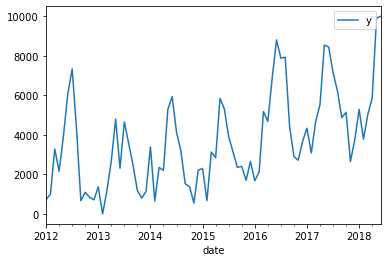

In [12]:
Y_train.query('key==95121').set_index('date')[['y']].plot()

# Checking and filling nas with zero for X_train, X_test 


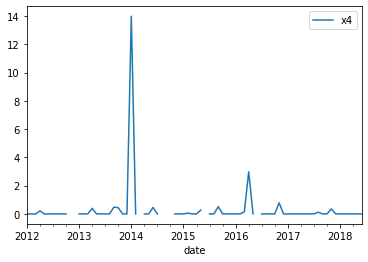

In [13]:
X_train.query('key==99444').set_index('date')[['x4']].plot()

## Looking at the above charts it is safe to replace Nulls with 0 for X_train

In [14]:
X_train=X_train.fillna(0)
X_test=X_test.fillna(0)

In [15]:
print(X_train.shape)
df_train=X_train.merge(Y_train,on=['key','date'],how='inner')
print(df_train.shape)

print(X_test.shape)
df_test=X_test.merge(Y_test,on=['key','date'],how='inner')
print(df_test.shape)

(8437, 114)
(8437, 115)
(1428, 114)
(1428, 115)


# Creating Features to input into LSTM model , taking a window of 24 months to predict the future 

In [17]:
df_train_1=df_train.set_index(['key','date']).unstack(level=1).fillna(0)
df_train_2=df_train_1.stack(level=1)
df_train_2=df_train_2.reset_index()
column_to_index='date'
month_seris=pd.Series(sorted(set(df_train_2[column_to_index])))
len_time_steps=24
starting_numeric_index=0
ending_numeric_index=len(month_seris)-len_time_steps
features_for_modelling=[]
target_for_modelling=[]
non_features_for_modelling=[]
feature_names=features_columns
target_names=['y']
non_features=['key','date']  # this will help us track if the array generated by the code is correct or not
for key in set(df_train_2.key):
    store_feature=df_train_2[df_train_2['key']==key]
    for i in np.arange(starting_numeric_index,ending_numeric_index):
        non_store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][non_features]
        store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][feature_names]
        target_feature_for_the_iteration=store_feature[store_feature[column_to_index]==month_seris[i+len_time_steps]][target_names]
        non_features_for_modelling.append(non_store_feature_for_the_iteration.values)
        features_for_modelling.append(store_feature_for_the_iteration.values)
        target_for_modelling.append(target_feature_for_the_iteration.values)
model_X=np.array(features_for_modelling)
target_Y=np.array(target_for_modelling)
non_feature_array=np.array(non_features_for_modelling)

In [18]:
#QCing if the code worked correctly

In [19]:
non_features_for_modelling[100]

array([[39943, Timestamp('2015-11-01 00:00:00')],
       [39943, Timestamp('2015-12-01 00:00:00')],
       [39943, Timestamp('2016-01-01 00:00:00')],
       [39943, Timestamp('2016-02-01 00:00:00')],
       [39943, Timestamp('2016-03-01 00:00:00')],
       [39943, Timestamp('2016-04-01 00:00:00')],
       [39943, Timestamp('2016-05-01 00:00:00')],
       [39943, Timestamp('2016-06-01 00:00:00')],
       [39943, Timestamp('2016-07-01 00:00:00')],
       [39943, Timestamp('2016-08-01 00:00:00')],
       [39943, Timestamp('2016-09-01 00:00:00')],
       [39943, Timestamp('2016-10-01 00:00:00')],
       [39943, Timestamp('2016-11-01 00:00:00')],
       [39943, Timestamp('2016-12-01 00:00:00')],
       [39943, Timestamp('2017-01-01 00:00:00')],
       [39943, Timestamp('2017-02-01 00:00:00')],
       [39943, Timestamp('2017-03-01 00:00:00')],
       [39943, Timestamp('2017-04-01 00:00:00')],
       [39943, Timestamp('2017-05-01 00:00:00')],
       [39943, Timestamp('2017-06-01 00:00:00')],


In [20]:
features_for_modelling[100][0]

array([-4.22416434e+01,  2.19771194e+02,  1.94529827e+03,  0.00000000e+00,
        1.18716995e+02,  0.00000000e+00,  3.25224707e+02,  8.67867100e+02,
        1.45102344e+02,  7.65536312e+01,  7.39464214e+01,  9.39912658e+02,
        0.00000000e+00,  0.00000000e+00,  1.42172648e+02,  8.73910920e+02,
        6.51542755e+00,  1.01306674e+03,  2.00132682e+03,  1.67192392e+03,
        0.00000000e+00,  9.17454210e+01,  1.94331833e+00,  0.00000000e+00,
        1.10653970e+03,  7.14410148e+00,  2.67862601e+01, -7.38240489e+00,
        3.03541627e+02,  0.00000000e+00,  2.51260161e+00,  0.00000000e+00,
        4.49080327e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.21348605e+02,  5.40916242e+03,  7.76675474e+02,  3.62259690e-01,
        2.04071510e+02,  0.00000000e+00,  2.53880319e+01,  6.65425146e-01,
        6.28150402e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.71259076e-01,  6.93856814e+00,  9.41194915e-01,
        3.30808927e+02,  

In [21]:
target_for_modelling[100]

array([[1739.753904]])

In [22]:
df_train.query('key==39943')

,key,date,x1,x2,x3,x4,x5,x6,x7,x8,...,x104,x105,x106,x107,x108,x109,x110,x111,x112,y
3204,39943,2015-01-01,0.000000,0.084830,0.000000,0.000000,8.099695,0.000000,17.954100,1.258629,...,123.137815,10.630113,46.858779,5.304635,0.000000,3.124220,0.706560,15.835844,0.000000,500.288019
3205,39943,2015-02-01,0.000000,0.550694,0.000000,0.000000,226.793460,0.000000,9.309890,52.203336,...,22.281936,4.088150,695.641313,892.368755,0.000000,2.521434,-0.269696,189.520014,72.831749,49.681132
3206,39943,2015-03-01,0.000000,0.510565,0.000000,0.000000,0.000000,0.000000,6.925108,341.997235,...,3.075749,0.000000,3.760479,3.324099,0.000000,4.432045,1.366664,3.054677,0.000000,1493.873619
3207,39943,2015-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.691286,0.000000,...,0.080235,0.000000,774.762726,20.552857,0.000000,5.712202,0.231507,294.986594,0.404943,1518.411436
3208,39943,2015-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.278829,201.339200,...,1.919982,0.000000,34.864799,1.964709,0.000000,6.989716,0.627906,10.824618,0.000000,3037.273940
3209,39943,2015-06-01,0.000000,0.000000,0.000000,1.139365,0.011519,0.000000,413.071691,3.960776,...,2.687361,0.000000,9.911066,-0.000031,0.000000,4.436694,0.000000,2.855609,0.000000,4056.743709
3210,39943,2015-07-01,0.000000,0.000000,0.000000,0.000000,42.331677,0.000000,0.961521,227.954086,...,3735.029991,11.283861,195.569398,16.971228,0.000000,1.894440,-8.517167,30.444421,4.000294,5650.093470
3211,39943,2015-08-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.360043,...,3.719334,0.000000,25.585055,36.032992,0.000000,1.889690,1.338387,22.667814,1.092652,3639.537303
3212,39943,2015-09-01,0.000000,0.000000,0.000000,0.166623,54.602182,0.000000,315.275179,70.198303,...,5.362570,0.000000,143.371823,56.148518,0.000000,1.886925,1.652273,112.668578,2.586124,1164.282276
3213,39943,2015-10-01,0.000000,0.000000,0.000000,0.980104,0.000000,0.000000,50.191459,3.198316,...,3.685123,0.031048,61.656691,51.119458,0.000000,2.512602,0.238181,7.323571,-3.621490,1032.635166


In [23]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length,output_values=1):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 40 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.output_values=output_values
        
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        #print(self.n_hidden)
        #print(self.seq_len)
        #print(seq_length)
        #print(self.n_hidden*self.seq_len)
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, output_values)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        #print(x.shape)
        #out=self.l_linear(x)
        x=F.relu(x)
        return self.l_linear(x)
        #return x,out
    
#criterion = torch.nn.MSELoss() 
criterion = torch.nn.L1Loss() #Because it was asked to used MAE loss which is same as L1 loss

   
n_features=model_X.shape[2]
n_timestep=model_X.shape[1]
output_values=target_Y.shape[2]
mv_net = MV_LSTM(n_features,n_timestep,output_values)

optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1)

model_X=torch.tensor(model_X,dtype=torch.float32)
target_Y=torch.tensor(target_Y,dtype=torch.float32)
index_tensor=torch.from_numpy(np.arange(model_X.shape[0]))
dataset = torch.utils.data.TensorDataset(model_X, target_Y,index_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#non_feature_array=torch.tensor(non_feature_array)
#feat_list=[non_feature_array,model_X,target_Y]

# running the model and appplying gradient clipping so that the gradient dont blow out of propotion

In [24]:
loss_list=[]
epochs=500
mv_net.train()
for e in range(epochs):
    batch_num=0
    for x_iter, y_iter,i_iter in dataloader:
        batch_num=batch_num+1
        
        optimizer.zero_grad()
        mv_net.init_hidden(x_iter.size(0))
        output=mv_net(x_iter).unsqueeze(1)
        loss = criterion(output, y_iter)
        
        loss.backward()
        clip_value=25
        torch.nn.utils.clip_grad_norm(mv_net.parameters(), clip_value)
        optimizer.step() 
        if batch_num%50==0:
            loss_list.append(round(loss.item()/len(i_iter),2))
        if e%20==0 and batch_num%50==0:
            print('epoch : ',e, 'batch_num : ' , batch_num , 'loss : ' , round(loss.item()/len(i_iter),2))

C:\Users\rathi\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
<ipython-input-24-4797a5a34c53>:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(mv_net.parameters(), clip_value)


epoch :  0 batch_num :  50 loss :  72.42
epoch :  0 batch_num :  100 loss :  55.37
epoch :  0 batch_num :  150 loss :  69.61
epoch :  0 batch_num :  200 loss :  53.17
epoch :  20 batch_num :  50 loss :  42.4
epoch :  20 batch_num :  100 loss :  46.08
epoch :  20 batch_num :  150 loss :  58.2
epoch :  20 batch_num :  200 loss :  45.78
epoch :  40 batch_num :  50 loss :  46.26
epoch :  40 batch_num :  100 loss :  40.63
epoch :  40 batch_num :  150 loss :  56.48
epoch :  40 batch_num :  200 loss :  66.66
epoch :  60 batch_num :  50 loss :  60.09
epoch :  60 batch_num :  100 loss :  48.04
epoch :  60 batch_num :  150 loss :  62.41
epoch :  60 batch_num :  200 loss :  54.27
epoch :  80 batch_num :  50 loss :  49.98
epoch :  80 batch_num :  100 loss :  52.47
epoch :  80 batch_num :  150 loss :  48.54
epoch :  80 batch_num :  200 loss :  63.1
epoch :  100 batch_num :  50 loss :  70.64
epoch :  100 batch_num :  100 loss :  61.94
epoch :  100 batch_num :  150 loss :  62.84
epoch :  100 batch_nu

In [25]:
df_train.date.max()

Timestamp('2018-06-01 00:00:00')

In [26]:
df_train.date.min()

Timestamp('2012-01-01 00:00:00')

In [27]:
#predicting one at a time
df_prediction=pd.concat([df_train,df_test])
df_prediction=df_prediction.sort_values(['key','date'])

In [28]:
df_train.date.max()

Timestamp('2018-06-01 00:00:00')

In [29]:
df_test

,key,date,x1,x2,x3,x4,x5,x6,x7,x8,...,x104,x105,x106,x107,x108,x109,x110,x111,x112,y
0,683,2018-07-01,0.000000,0.000000,0.397238,0.000000,0.000000,0.000000,119.936184,114.063630,...,1.064945,0.000000,11762.888680,544.321043,0.000000,39.599762,7.289597,2895.006107,48.666357,NaN
1,683,2018-08-01,0.000000,0.000000,0.000000,0.000000,74.832787,0.000000,593.803092,0.000000,...,-4.437491,0.141846,130.027455,84.134454,0.357027,33.098055,17.244210,97.633777,3.189301,NaN
2,683,2018-09-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,222.106715,7.926074,...,42.879114,1.003184,0.000000,0.000000,0.000000,8.638553,0.000000,0.000000,0.000000,NaN
3,683,2018-10-01,1.532104,0.576041,0.000000,0.000000,52.540417,21.890773,59.588630,361.870895,...,196.748088,43.919361,102.735687,2.731286,0.000000,14.646718,2.719439,48.866957,0.267833,NaN
4,683,2018-11-01,0.000000,0.000000,0.000000,2.412814,19.021238,42.032333,1970.406869,6.444104,...,17.802426,1.605068,71.384402,131.866917,0.000000,-7.336147,2.190175,43.717736,0.833723,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,99444,2019-02-01,0.167286,0.000000,0.000000,0.000000,3.563444,0.213637,28.683344,671.811450,...,717.566996,85.346233,53.162367,19.132707,0.000000,52.082725,0.764603,52.860076,0.262702,NaN
1424,99444,2019-03-01,0.000000,0.000000,0.000000,6.384198,0.000000,11.074499,114.679868,6.508677,...,1.305665,0.000000,11.386100,54.527628,0.000000,142.196722,0.356890,6.263746,0.000000,NaN
1425,99444,2019-04-01,0.317642,0.000000,0.000000,0.000000,0.000000,0.000000,3614.023857,575.320377,...,1.137027,0.284562,2.814448,1.763244,0.000000,165.414227,0.038380,0.128338,0.073461,NaN
1426,99444,2019-05-01,0.000000,0.000000,0.677903,0.000000,0.000000,0.000000,677.526635,8.384144,...,-3.339612,13.501808,28.990518,16.069213,0.026931,58.296873,3.361134,3.618718,0.000000,NaN


In [30]:
# month_init=pd.to_datetime("2018-07-01")
# for key in set(df_prediction.keys):
    

In [31]:
df_train_1=df_train.set_index(['key','date']).unstack(level=1).fillna(0)
df_train_2=df_train_1.stack(level=1)
df_train_2=df_train_2.reset_index()
column_to_index='date'
month_seris=pd.Series(sorted(set(df_train_2[column_to_index])))
len_time_steps=24
starting_numeric_index=0
ending_numeric_index=len(month_seris)-len_time_steps
features_for_modelling=[]
target_for_modelling=[]
non_features_for_modelling=[]
feature_names=features_columns
target_names=['y']
non_features=['key','date']  # this will help us track if the array generated by the code is correct or not
for key in set(df_train_2.key):
    store_feature=df_train_2[df_train_2['key']==key]
    for i in np.arange(starting_numeric_index,ending_numeric_index):
        non_store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][non_features]
        store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][feature_names]
        target_feature_for_the_iteration=store_feature[store_feature[column_to_index]==month_seris[i+len_time_steps]][target_names]
        non_features_for_modelling.append(non_store_feature_for_the_iteration.values)
        features_for_modelling.append(store_feature_for_the_iteration.values)
        target_for_modelling.append(target_feature_for_the_iteration.values)
model_X=np.array(features_for_modelling)
target_Y=np.array(target_for_modelling)
non_feature_array=np.array(non_features_for_modelling)

In [32]:
df_train.date.max()

Timestamp('2018-06-01 00:00:00')

In [33]:
non_features_for_modelling[53]

array([[77827, Timestamp('2016-06-01 00:00:00')],
       [77827, Timestamp('2016-07-01 00:00:00')],
       [77827, Timestamp('2016-08-01 00:00:00')],
       [77827, Timestamp('2016-09-01 00:00:00')],
       [77827, Timestamp('2016-10-01 00:00:00')],
       [77827, Timestamp('2016-11-01 00:00:00')],
       [77827, Timestamp('2016-12-01 00:00:00')],
       [77827, Timestamp('2017-01-01 00:00:00')],
       [77827, Timestamp('2017-02-01 00:00:00')],
       [77827, Timestamp('2017-03-01 00:00:00')],
       [77827, Timestamp('2017-04-01 00:00:00')],
       [77827, Timestamp('2017-05-01 00:00:00')],
       [77827, Timestamp('2017-06-01 00:00:00')],
       [77827, Timestamp('2017-07-01 00:00:00')],
       [77827, Timestamp('2017-08-01 00:00:00')],
       [77827, Timestamp('2017-09-01 00:00:00')],
       [77827, Timestamp('2017-10-01 00:00:00')],
       [77827, Timestamp('2017-11-01 00:00:00')],
       [77827, Timestamp('2017-12-01 00:00:00')],
       [77827, Timestamp('2018-01-01 00:00:00')],


# Predicting for 12 months

In [34]:
#predicting one at a time
df_prediction=pd.concat([df_train,df_test])
df_prediction=df_prediction.sort_values(['key','date'])

In [35]:
print(df_prediction.date.min())
print(df_test.date.max())

2012-01-01 00:00:00
2019-06-01 00:00:00


In [36]:
from datetime import date
from dateutil.relativedelta import relativedelta
st_date = date(2018,7,1)
df_final = pd.DataFrame()
j = 0
while(j < 12 ):
    
    new_date = st_date+relativedelta(months=+j)
    
    month_current=pd.to_datetime(new_date)
    month_final=month_current
    month_final=month_final.replace(day=1)
    month_initial=month_final- timedelta(days=2*365)
    month_initial=month_initial.replace(day=1)
#     print(month_current,month_final,month_initial)
    df_to_predict=df_prediction[(df_prediction['date']>=month_initial)&\
                                (df_prediction['date']<=month_current)]
    
    
    
    df_train_1=df_to_predict.set_index(['key','date']).unstack(level=1).fillna(0)
    df_train_2=df_train_1.stack(level=1)
    df_train_2=df_train_2.reset_index()
    column_to_index='date'
    month_seris=pd.Series(sorted(set(df_train_2[column_to_index])))
    len_time_steps=24
    starting_numeric_index=0
    ending_numeric_index=len(month_seris)-len_time_steps
    features_for_modelling=[]
    target_for_modelling=[]
    non_features_for_modelling=[]
    feature_names=features_columns
    target_names=['y']
    non_features=['key','date']  # this will help us track if the array generated by the code is correct or not
    for key in set(df_train_2.key):
        store_feature=df_train_2[df_train_2['key']==key]
        for i in np.arange(starting_numeric_index,ending_numeric_index):
            non_store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][non_features]
            store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][feature_names]
            target_feature_for_the_iteration=store_feature[store_feature[column_to_index]==month_seris[i+len_time_steps]][target_names]
            non_features_for_modelling.append(non_store_feature_for_the_iteration.values)
            features_for_modelling.append(store_feature_for_the_iteration.values)
            target_for_modelling.append(target_feature_for_the_iteration.values)
    model_X=np.array(features_for_modelling)
    target_Y=np.array(target_for_modelling)
    non_feature_array=np.array(non_features_for_modelling)

    mv_net.eval()
    with torch.no_grad():
        pred_x=torch.tensor(model_X,dtype=torch.float32)
        mv_net.init_hidden(pred_x.size(0))
        mv_net(pred_x)
        
    pd.DataFrame({mv_net(pred_x)})
    pred_arr = mv_net(pred_x).detach().numpy()
    
    df = pd.DataFrame(pred_arr)
    df_final=pd.concat([df_final,df])
    print(df_final)
    j = j +1
    
    


               0
0    3954.910645
1    3939.163086
2    3785.151367
3    3954.910645
4    3954.910645
..           ...
114  3872.054443
115  3954.910645
116  4073.096436
117  3744.260254
118  3954.910889

[119 rows x 1 columns]
               0
0    3954.910645
1    3939.163086
2    3785.151367
3    3954.910645
4    3954.910645
..           ...
114  3844.822754
115  3954.910645
116  3993.408936
117  4105.242676
118  3954.910889

[238 rows x 1 columns]
               0
0    3954.910645
1    3939.163086
2    3785.151367
3    3954.910645
4    3954.910645
..           ...
114  4008.288574
115  3954.910645
116  3861.727783
117  4177.797363
118  3954.910889

[357 rows x 1 columns]
               0
0    3954.910645
1    3939.163086
2    3785.151367
3    3954.910645
4    3954.910645
..           ...
114  3762.437256
115  3954.910645
116  4046.605713
117  4062.877930
118  3954.910889

[476 rows x 1 columns]
               0
0    3954.910645
1    3939.163086
2    3785.151367
3    3954.910645
4  

In [37]:
df_final.to_csv('nestle.csv', index = False)

In [38]:
Y_test=pd.read_csv('Y_test.csv',sep=';')
Y_test['date']=pd.to_datetime(Y_test['date'])
df_test = pd.DataFrame(Y_test)
df_date_sort=df_test.sort_values(by = ['date'])

# print(df_date_sort)
df_date_sort.to_csv('sort.csv')

predictions = pd.read_csv('nestle.csv')
df_pred = pd.DataFrame(predictions)

df_date_sort['y'] = df_pred['0'].astype(int)
# print(df_date_sort)

df_key_sort = df_date_sort.sort_values(by= ['key'])
print(df_key_sort)

df_key_sort.to_csv('nestle_final_pred.csv', index = False)

        key       date     y
0       683 2018-07-01  3954
9       683 2019-04-01  3954
8       683 2019-03-01  3954
11      683 2019-06-01  3954
7       683 2019-02-01  3954
...     ...        ...   ...
1416  99444 2018-07-01  3983
1419  99444 2018-10-01  3954
1418  99444 2018-09-01  3954
1426  99444 2019-05-01  3513
1427  99444 2019-06-01  3954

[1428 rows x 3 columns]
